# CosmoDC2 - Hack on Halos

# Galaxy Clusters & Velocity: A HackUrDC2 Story

Author: Julien Peloton [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-01-06  
Estimated running time: < 15 min.

**Context**

This notebook illustrates the basics of accessing the cosmoDC2 catalog through Apache Spark as well as how to select useful samples of data to study galaxy clusters. 

**Science results or validation?**

While it describes some of the science results you can get with the DC2 catalog (e.g. halo mass-velocity dispersion relation), it shifted towards the validation side, especially on the halo mass distribution. So it is a bit of both! After going through this notebook, you should be able to:

- Load and efficiently access the cosmoDC2 catalog with Apache Spark
- Apply cuts to the catalog using Spark SQL functionalities
- Have several example of quality cuts and validation procedures 
- Derive scientific results on galaxy clusters
- Distribute the computation and the plotting routine to be faster!

**Table of contents:**
- Loading cosmoDC2 data with Apache Spark
- Halo mass distribution
  - issue: https://github.com/LSSTDESC/DC2-analysis/issues/55
- Galaxy clusters and velocity
  - A few individual galaxy clusters
  - A wider region of space
  - Mean velocity as a function of redshift
- The velocity dispersion–halo mass relation
  - issue: https://github.com/LSSTDESC/DC2-analysis/issues/57
- Visualising masses in the cosmoDC2 Universe
- Outro: Towards large data sets with Apache Spark



In [2]:
from typing import Iterator, Generator, Any

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

from scipy.optimize import curve_fit

from pyspark.sql.functions import pandas_udf , PandasUDFType
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

In [6]:
from time import time

# Spark Session

In [7]:
# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

#usefull class to benchmark
class Timer:
    """ A simple class for printing elapsed time (s) since last call
    """
    def __init__(self):
        self.t0 = time()
    
    def start(self):
        self.t0 = time()
        
    def split(self):
        t1 = time()
        print("{:2.1f}s".format(t1 - self.t0))

timer = Timer()

spark session started


# Loading CosmoDC2 data with Spark

Apache Spark has no efficient PySpark connector to read data in hdf5 file. Therefore we first converted the cosmoDC2 data set into parquet (similar to what DPDD tools offer). For the purpose of this notebook, we only convert a few columns of interest. The file is accessible at NERSC for DESC members.

In [8]:
! hadoop dfs -ls /lsst/DC2/cosmoDC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 5 items
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-09-03 20:04 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-10-16 10:52 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-04-23 17:28 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-09-07 19:17 /lsst/DC2/cosmoDC2/shear_cosmoDC2
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-04-16 18:40 /lsst/DC2/cosmoDC2/xyz_v1.1.4_hive


In [16]:
timer.start()

# Path to cosmoDC2 (parquet format)
filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image.parquet"
#filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet"
#filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet"

# Spark DataFrame
df = spark.read.parquet(filename)

# Le's inspect the schema of the data
df.printSchema()

# Number of objects in the catalog
print("Number of rows: {}".format(df.count()))

timer.split()

root
 |-- Mag_true_g_lsst_z0: float (nullable = true)
 |-- Mag_true_z_lsst_z0: float (nullable = true)
 |-- ra: float (nullable = true)
 |-- mag_y: float (nullable = true)
 |-- mag_z: float (nullable = true)
 |-- size_true: float (nullable = true)
 |-- halo_id: long (nullable = true)
 |-- position_x: float (nullable = true)
 |-- mag_g: float (nullable = true)
 |-- Mag_true_u_lsst_z0: float (nullable = true)
 |-- mag_true_r: float (nullable = true)
 |-- position_angle_true: float (nullable = true)
 |-- mag_true_g: float (nullable = true)
 |-- stellar_mass: float (nullable = true)
 |-- Mag_true_y_lsst_z0: float (nullable = true)
 |-- position_y: float (nullable = true)
 |-- mag_true_i: float (nullable = true)
 |-- redshift: float (nullable = true)
 |-- Mag_true_i_lsst_z0: float (nullable = true)
 |-- mag_r: float (nullable = true)
 |-- mag_true_y: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- mag_true_u: float (nullable = true)
 |-- Mag_true_r_lsst_z0: float (nullable = 

Let's have a look a some mass values. Apache Spark provides filter mechanisms, which you can use to speed up data access if you only need a certain chunks of the dataset:

In [17]:
# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
#cols = ["halo_mass", "stellar_mass", "blackHoleMass", "halo_id"]
cols = ["stellar_mass", "halo_id"]
df.filter("halo_id > 0").select(cols).show(5)

+-------------+---------+
| stellar_mass|  halo_id|
+-------------+---------+
|1.61537874E10|   151487|
| 1.45056048E8|   151487|
| 3.39115392E8|100151487|
| 2.54158784E8|200151487|
| 2.73879296E9|300151487|
+-------------+---------+
only showing top 5 rows



In [18]:
# Let's look at the stellar_mass and halo_mass distributions
df.select(["stellar_mass", "redshift"]).describe().show(5)

+-------+-------------------+------------------+
|summary|       stellar_mass|          redshift|
+-------+-------------------+------------------+
|  count|         2256249331|        2256249331|
|   mean|4.327470113240803E8|1.8710546226480738|
| stddev|5.673531539648363E9|0.7098291050264712|
|    min|          3536.0823|       4.017382E-4|
|    max|       4.5117179E12|         3.1891842|
+-------+-------------------+------------------+



# Halo mass distribution in DC2

To start this journey, let's look at the distribution of halo masses in the DC2 data set.
We will select only clusters with positive halo-ids (i.e. we reject the synthetic halos that are added to host the ultra-faint galaxies). In addition, we will create two other populations: low-z (0.0 < z < 0.2), and high-z (2.5 < z < 3.1) clusters.

In [19]:
# We cache the data for speeding up later computations
df_mass = df.filter('is_central == True').filter("halo_id > 0").select("stellar_mass").cache()

# Populations based on redshift range
df_mass_lowz = df_mass.filter("redshift < 0.2")
df_mass_highz = df_mass.filter("redshift > 2.5")

Since the number of clusters is rather high, we will capitalize on the fact that we are doing computation in parallel.
The way to be faster is to distribute the computation which leads to the data to be plotted. Histograms are particularly easy to distribute:
- Load the data set across several partitions. Each partition has about 128 MB of data.
- Apply filters on lines and select columns (order does not matter as Spark will choose the optimal way). Partitions will be processed in parallel. If you have more partitions than workers (typically CPU), there will be a partition queue.
- With the remaining data in each partition, build an histogram per partition.
- Reduce to the driver all partition histograms by summing them up. You have the final histogram!

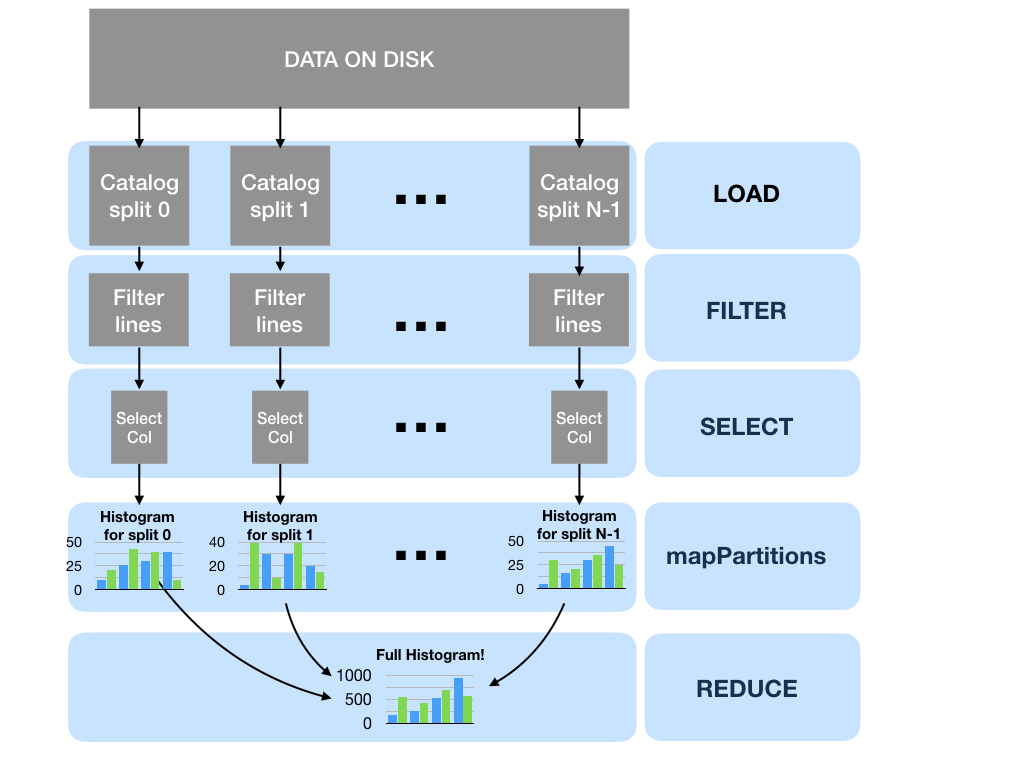

In [20]:
# Illustration of the text above
Image('histo_spark.png')

Let's write such a method to be applied on each Spark partition to compute histograms in parallel (each would contain only a fraction of the data):

In [21]:
def partition_hist(partition: Iterator, bins : np.ndarray = None) -> Generator:
    """ Produce histograms from partition data
    
    Parameters
    ----------
    partition : Iterator
        Iterator containing partition data *[x].
        
    Returns
    ----------
    Generator yielding histograms for each partition. 
    Counts is an array of dimension nbins - 1.
    """
    # Unwrap the iterator
    mass = [*partition]
    
    (counts, edges) = np.histogram(mass, bins)
    
    yield counts

def parallel_hist(df: DataFrame, bins : np.ndarray, col: str = None) -> np.ndarray:
    """ Build an histogram of the data in parallel
    
    Parameters
    ----------
    df : DataFrame
        Apache Spark DataFrame.
    bins : 1D numpy array
        The bin edges, including the rightmost edge.
    col : str, optional
        Column to select. If None, the DataFrame is
        expected to have only one column. Default is None.
        
    Returns
    ----------
    hist : 1D numpy array
        Full histogram over `bins` for the selected DataFrame column.
        hist has dimension len(bins) - 1.

    """
    # Go from DataFrame to RDD world
    if col is None:
        rdd = df.rdd
    else:
        rdd = df.select(col).rdd
        
    # Build the histograms in each partition
    hist = rdd\
        .mapPartitions(lambda partition: partition_hist(partition, bins))\
        .reduce(lambda x, y: x+y)

    return hist

In [22]:
# Binning of mass in log space
bins = np.logspace(8, 15, 50)

# Build histograms for the 3 populations
dataplot = []
for index, dataframe in enumerate([df_mass, df_mass_lowz, df_mass_highz]):
    # This is the crucial part - build the plot data in parallel, and
    # reduce the final result to the driver. Scalable to Billions of points!
    dataplot.append(parallel_hist(dataframe, bins))

Entries for All redshifts : 153443835 (100.0%)
Entries for 0.0 < z < 0.2 : 364243 (0.2%)
Entries for 2.5 < z < 3.1 : 27758680 (18.1%)


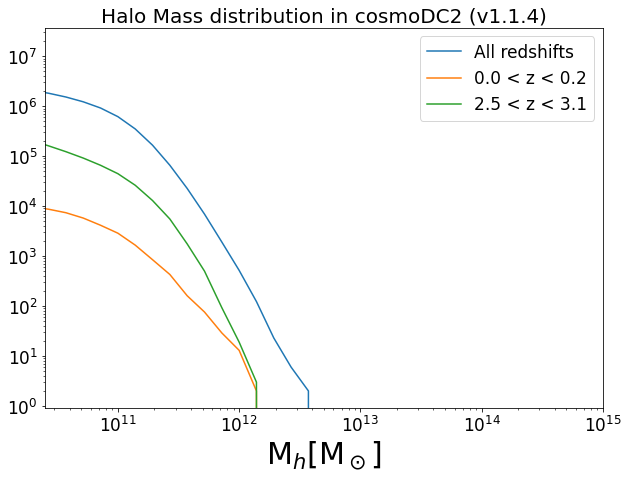

In [23]:
# Plot the result
matplotlib.rcParams.update({'font.size': 17})
labels = ["All redshifts", "0.0 < z < 0.2", "2.5 < z < 3.1"]

fig = plt.figure(figsize=(10, 7))
for index in range(len(dataplot)):
    plt.loglog(bins[:-1], dataplot[index], label=labels[index])
    print('Entries for {} : {} ({:.1f}%)'.format(
        labels[index], 
        np.sum(dataplot[index]), 
        np.sum(dataplot[index])/np.sum(dataplot[0])*100))
plt.legend()

plt.xlim(2.5e10, 1e15)
plt.title('Halo Mass distribution in cosmoDC2 (v1.1.4)', fontsize=20)
plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.show()

# A weird feature!

We selected the clusters based on their `halo_id`, and to avoid double counting we took only entries corresponding to central galaxies (all galaxies for a given `halo_id` have the same `halo_mass`).

If now we look closely at the `halo_mass` distribution values, we observe a weird feature:

In [25]:
df1 = df.filter('is_central == True').filter("halo_id > 0").select('stellar_mass')
df2 = df.filter('is_central == True').filter("halo_id > 0").select('stellar_mass').distinct()

print("All halo_mass values: {}".format(df1.count()))
print("All distinct halo_mass values: {}".format(df2.count()))

All halo_mass values: 241445447
All distinct halo_mass values: 79285520


There many different halos (i.e. different position on sky) with exactly the same mass! Note that we already select central galaxies to grab the value of the halo mass. Let's look at both distributions:

In [26]:
# Build plots in parallel - millions of points!
data1 = parallel_hist(df1, bins)
data2 = parallel_hist(df2, bins)

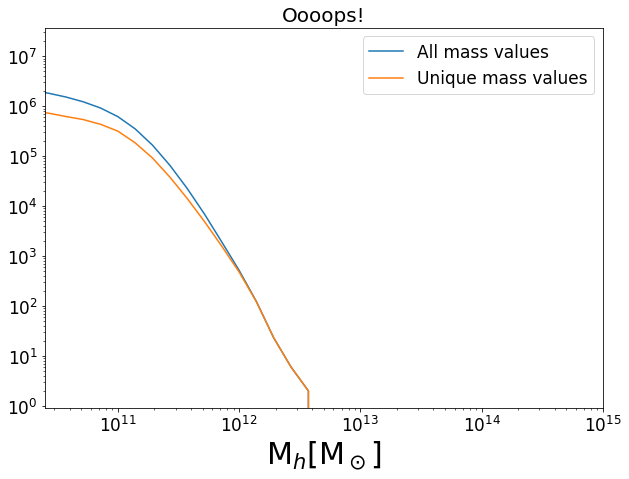

In [27]:
# Plot the result
matplotlib.rcParams.update({'font.size': 17})
plt.figure(figsize=(10, 7))
plt.loglog(bins[:-1], data1, label="All mass values")
plt.loglog(bins[:-1], data2, label="Unique mass values")
plt.title("Oooops!", fontsize=20)
plt.xlim(2.5e10, 1e15)
plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.legend()
plt.show()

That means many halos with mass lower than $10^{13} {\rm M}_\odot$ have the same mass.

**Question**: Is that expected?

**Answer:** Yes! This is the so-called mass quantization in N-body simulations: all halo masses must by definition be some integer times the particle mass value used in the simulations (a few times 10^9 solar masses). For a detailed discussion, see https://github.com/LSSTDESC/DC2-analysis/issues/55. OK, this one was easy to solve...!

# Galaxy clusters and velocity in DC2

### A few individual galaxy clusters

Let's now focus on some selected galaxy clusters. We will select 5 rich ones ($n_{gal} > 50$), and look at their spatial morphology (in comoving cartesian coordinates), plus the 3D velocity of their members.

In [28]:
# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
df_halo = df.filter("halo_id > 0")

# Group by halo_id, and count members
df_halo_grouped = df_halo.groupBy("halo_id").count().filter("count > 50")
df_halo_grouped.show(5)

# Take the 5 first
halos = df_halo_grouped.select("halo_id").take(5)

+-------------+-----+
|      halo_id|count|
+-------------+-----+
| 776800151224|   66|
| 424900151373|  111|
|4966500151171|   65|
|2308800151148|   76|
| 833500152300|  158|
+-------------+-----+
only showing top 5 rows



We will collect halos data into Pandas DataFrame. Why using Pandas? to show that you can go from Spark world to Pandas world easily (and also for fun):

In [30]:
# Select position, velocity, stellar mass and redshift
#cols_3d = ["position_x", "position_y", "position_z", "velocity_x", "velocity_y", "velocity_z"]
cols_3d = ["position_x", "position_y", "position_z"]
cols = cols_3d + ["stellar_mass", "redshift"]
pandas_dfs = []
for halo in halos:
    # Keep only members of the halo
    halo_id = np.array(halo)[0]
    df_members = df_halo.filter("halo_id == {}".format(halo_id)).select(cols)
    
    # Halo members
    pandas_df = df_members.toPandas()
    
    # Central galaxy
    pandas_df_center = df_members.filter("is_central == True").toPandas()
    
    pandas_dfs.append([pandas_df, pandas_df_center])

Note however that `toPandas()` sends back the data from all the executors to the lonely poor driver. So be careful to not use that on TB of data!

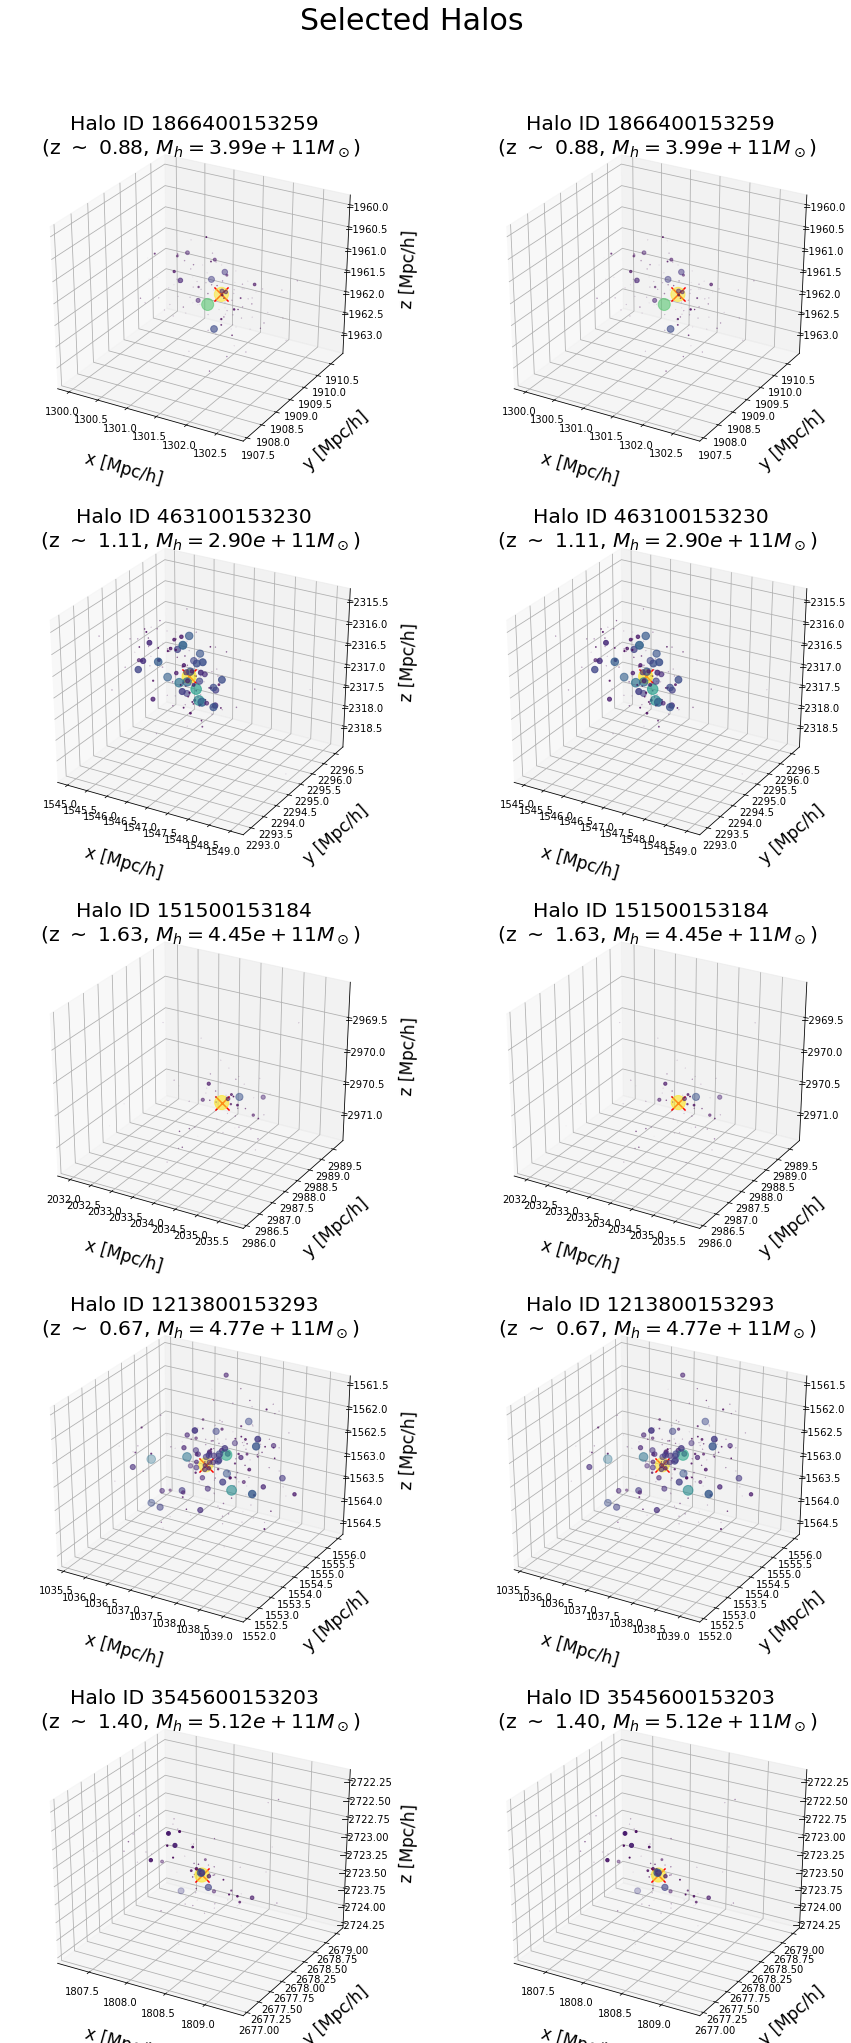

In [33]:
matplotlib.rcParams.update({'font.size': 17})
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 35))
fig.suptitle('Selected Halos', y=0.93, fontsize=30)

for index, halo, pdfs in zip(range(len(halos)), halos, pandas_dfs):
    
    # First plot column: position of members, color coded with stellar mass
    ax = fig.add_subplot(5, 2, 2*index + 1, projection='3d')
    mass_scale = pdfs[0].stellar_mass / pdfs[0].stellar_mass.max() * 200
    halo_id = np.array(halo)[0]
    zmean = pdfs[1].redshift.mean()
    halo_mass = pdfs[1].stellar_mass.mean()
    
    ax.scatter(
        pdfs[0].position_x, 
        pdfs[0].position_y, 
        pdfs[0].position_z, s=mass_scale, c=mass_scale)
    ax.scatter(
        pdfs[1].position_x, 
        pdfs[1].position_y, 
        pdfs[1].position_z, 
        s=200, color="red", marker="x")
    ax.set_title(
        'Halo ID {} \n (z $\sim$ {:.2f}, $M_h = {:.2e} M_\odot$)'.format(
            halo_id, zmean, halo_mass))
    ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
    ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
    ax.set_zlabel(r'z [Mpc/h]', labelpad=20)
    ax.tick_params(axis='both', labelsize=10)

    # Second plot column: position of members + 3D velocity, 
    # color coded with stellar mass.
    ax = fig.add_subplot(5, 2, 2*index + 2, projection='3d')
    ax.scatter(
        pdfs[0].position_x, 
        pdfs[0].position_y, 
        pdfs[0].position_z, s=mass_scale, c=mass_scale)
    #q = ax.quiver(
    #    pdfs[0].position_x, 
    #    pdfs[0].position_y, 
    #    pdfs[0].position_z, 
    #    pdfs[0].velocity_x, 
    #    pdfs[0].velocity_y, 
    #    pdfs[0].velocity_z, length=0.0002, color='k')
    ax.scatter(
        pdfs[1].position_x, 
        pdfs[1].position_y, 
        pdfs[1].position_z, 
        s=200, color="red", marker="x")
    ax.set_title(
        'Halo ID {} \n (z $\sim$ {:.2f}, $M_h = {:.2e} M_\odot$)'.format(
            halo_id, zmean, halo_mass))
    ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
    ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
    ax.set_zlabel(r'z [Mpc/h]', labelpad=20)
    ax.tick_params(axis='both', labelsize=10)
plt.show()

Color code: 
- yellow = big = more massive, 
- purple = small = less massive

Note that for the 2nd and 4th halos the velocities seem to be aligned along an axis as if they were following some flow. 
On the third halo, galaxies seem to rotate around the center. 

### A wider region of space

Let's have a look at a wider region of space. We focus on a cube of 15 Mpc size (~ 2000 halos), compute and display the mean velocity for each halo:

In [35]:
# Select columns of interest
cols = ["halo_id", "position_x", "position_y", "position_z", "redshift", "is_central"]
cols_vel = ["velocity_x", "velocity_y", "velocity_z"]
cols_mass = ["stellar_mass"]
#df_sub = df.select(cols + cols_mass + cols_vel).filter("halo_id > 0")
df_sub = df.select(cols + cols_mass).filter("halo_id > 0")

In [36]:
# Get the mean position of our cube of data
df_stat = df_sub.select(["position_x", "position_y", "position_z"]).describe()
means = df_stat.collect()[1]

m_x = float(means['position_x'])
m_y = float(means['position_y'])
m_z = float(means['position_z'])

In [37]:
# Size of our data cube
Mpc = 15.

# Keep only this region of space
dfcut = df_sub.filter(
    (F.abs(df_sub.position_x - m_x) < Mpc) &
    (F.abs(df_sub.position_y - m_y) < Mpc) &
    (F.abs(df_sub.position_z - m_z) < Mpc))

In [ ]:
# Group data by halos and compute the mean velocity
df_disp = dfcut.groupBy("halo_id").agg({
    "velocity_x": 'mean',
    "velocity_y": 'mean',
    "velocity_z": 'mean'})

# Add back original columns, and 
# select only a few columns for the plot
data_joined = dfcut.join(df_disp, "halo_id")\
    .filter("is_central == True")\
    .select(
    "avg(velocity_x)", "avg(velocity_y)", 'avg(velocity_z)', 
    "position_x", "position_y", "position_z", 
    'redshift', 'halo_mass')

# Show a few columns 
data_joined.show(5)

# Go to Pandas world for the plot
pandas_df = data_joined.toPandas()

In [ ]:
matplotlib.rcParams.update({'font.size': 17})

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
q = ax.quiver(
    pandas_df.position_x, 
    pandas_df.position_y, 
    pandas_df.position_z, 
    pandas_df["avg(velocity_x)"], 
    pandas_df["avg(velocity_y)"], 
    pandas_df["avg(velocity_z)"], length=0.0005, color='k')
ax.scatter(
    pandas_df.position_x, 
    pandas_df.position_y, 
    pandas_df.position_z, 
    s=pandas_df.halo_mass/pandas_df.halo_mass.max()*400, c='r')
plt.title(
    'Mean 3D velocity of halos (z $\sim$ {:.2f})'.format(pandas_df.redshift.mean()))
ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
ax.set_zlabel(r'z [Mpc/h]', labelpad=20)
ax.tick_params(axis='both', labelsize=10)
plt.show()

We show the 3D mean velocity (black arrow) for each halo contained in this data cube (15 Mpc size). We also superimposed the halo mass (red circle). The bigger is the circle, the more massive is the halo. It is interesting to notice that most massive halos are surrounded by halos with large velocities, they seem to flow towards them.

With more times, that would be interesting to study other properties and the environment of those halos and see whether there is a correlation with the velocities.

# Mean velocity as a function of redshift

To end this journey, let's have a look at the mean velocity distribution as a function of redshift:

In [38]:
# Redshift range
redshift_start = 0.0
redshift_stop = 3.0
redshift_step = 0.5
redshift_window = 0.1
values = np.arange(redshift_start, redshift_stop, redshift_step)

# start at 0.2 because stat is poor at very low redshift
values[0] = 0.2